# MoSeq Pipeline Tutorial

This notebook provides a tutorial on how to use the MoSeq pipeline to analyze behavioral data. The pipeline is a tool for taking keypoint pose estimations and extracting behavioral syllables.

*Note: Moseq is an optional dependency within the spyglass package. For installation
instructions, see the [setup tutorial](./00_Setup.ipynb)

Here is a schematic showing the tables used in this pipeline. The Basic steps are:
> **Model Training**
> - Define training data in `PoseGroup`
>  - Define Moseq model and training parameters in `MoseqModelParams`
>  - Combine a set of training parameters and training data in `MoseqModelSelection`
>  - Populate `MoseqModel` to train
> 
> **Convert pose data to behavioral syllables**
>  - Combine a trained model from `MoseqModel` and a pose data from `PositionOutput` in 
`MoseqSyllableSelection`
>  - Populate  `MoseqSyllable` to apply the trained model to the selected data

![moseq_outline.png|2000x900](./../notebook-images/moseq_outline.png)


 # Accessing the keypoint (pose) data

In the spyglass architecture, keypoint tracking is performed in the `Position` module,
and can be accessed through `PositionOutput.fetch_pose_dataframe()`. In this tutorial,
we are using a set of unpublished data from the Frank lab. For a tutorial on
running keypoint extraction in spyglass, see [the DLC tutorial notebook](21_DLC.ipynb).

We can access an example set of keypoint pose data here:

In [ ]:
%load_ext autoreload
%autoreload 2
from spyglass.position.position_merge import PositionOutput

# Key defining the DLC data we are using
pose_key = {
    "nwb_file_name": "SC100020230912_.nwb",
    "epoch": 9,
    "video_file_num": 14,
    "project_name": "sideHomeOfficial",
    "dlc_model_name": "sideHomeOfficial_tutorial_00",
    "dlc_model_params_name": "default",
    "task_mode": "trigger",
}

# Fetch the pose data for demo purposes
merge_key = (PositionOutput.DLCPosV1 & pose_key).fetch1("KEY")
pose_df = (PositionOutput & merge_key).fetch_pose_dataframe()
pose_df

earL                                       \
             video_frame_ind            x            y likelihood   
time                                                                
1.694621e+09             0.0  8072.609849  3759.525550   0.825574   
1.694621e+09             1.0  8261.998988  3770.095027   0.863721   
1.694621e+09             2.0  8439.114777  3755.394062   0.904633   
1.694621e+09             3.0  8076.690548  3533.975641   0.496637   
1.694621e+09             4.0  8093.694597  3484.686411   0.742271   
...                      ...          ...          ...        ...   
1.694622e+09         23859.0  8323.301275  4157.022004   0.002994   
1.694622e+09         23860.0  8322.580462  4164.396172   0.000736   
1.694622e+09         23861.0  8313.878944  4136.119901   0.002430   
1.694622e+09         23862.0  8326.235314  4170.750165   0.000500   
1.694622e+09         23863.0  7906.806815  4096.058880   0.002833   

                        earR                                       \
             video_frame_ind            x            y likelihood   
time                                                                
1.694621e+09             0.0  7883.074692  3895.790402   0.028869   
1.694621e+09             1.0  8225.103732  3798.036042   0.216548   
1.694621e+09             2.0  8147.386840  3806.549055   0.710284   
1.694621e+09             3.0  8238.187752  3744.631928   0.976969   
1.694621e+09             4.0  8284.158606  3675.837536   0.889797   
...                      ...          ...          ...        ...   
1.694622e+09         23859.0  8323.682192  4137.912654   0.002425   
1.694622e+09         23860.0  8319.023281  4144.923485   0.001018   
1.694622e+09         23861.0  7611.079736  4317.360829   0.003122   
1.694622e+09         23862.0  8321.127116  4151.999268   0.001903   
1.694622e+09         23863.0  7560.711728  3926.797069   0.002349   

                   forelimbL               ...     tailBase             \
             video_frame_ind            x  ...            y likelihood   
time                                       ...                           
1.694621e+09             0.0  7656.537329  ...  4283.328800   0.999663   
1.694621e+09             1.0  7601.948953  ...  4330.051234   0.999686   
1.694621e+09             2.0  7613.715879  ...  4325.570084   0.999876   
1.694621e+09             3.0  7688.181299  ...  4370.041688   0.999769   
1.694621e+09             4.0  7745.837035  ...  4458.699207   0.999916   
...                      ...          ...  ...          ...        ...   
1.694622e+09         23859.0  7615.597512  ...  4085.460346   0.002940   
1.694622e+09         23860.0  7612.563848  ...  4092.408667   0.000326   
1.694622e+09         23861.0  7631.078869  ...  4087.278981   0.001913   
1.694622e+09         23862.0  7620.843915  ...  4209.775628   0.000241   
1.694622e+09         23863.0  7911.580490  ...  4079.302183   0.003016   

                     tailMid                                       \
             video_frame_ind            x            y likelihood   
time                                                                
1.694621e+09             0.0  4959.599074  4041.634348   0.845290   
1.694621e+09             1.0  5007.866176  4112.705698   0.919689   
1.694621e+09             2.0  5076.785832  4131.337436   0.978790   
1.694621e+09             3.0  5155.758285  4173.914220   0.956584   
1.694621e+09             4.0  5424.312777  4266.901987   0.949616   
...                      ...          ...          ...        ...   
1.694622e+09         23859.0  7892.239171  4094.556699   0.019522   
1.694622e+09         23860.0  2442.091901   833.311661   0.002724   
1.694622e+09         23861.0  7888.670269  4099.420475   0.014236   
1.694622e+09         23862.0  7885.540888  4096.438577   0.000256   
1.694622e+09         23863.0  7877.772617  4084.137146   0.026200   

                     tailTip                                       
             video

To train a moseq model, we first need to define the epochs of pose data we will train on
as well as the bodyparts to use within the model. We define this in the `PoseGroup`
table below.

Note that training can be run using data from multiple epochs by passing a list of
merge ids to `create_group`

In [ ]:
from spyglass.behavior.v1.core import PoseGroup

# Define the group name and bodyparts to include in the Moseq model
group_name = "tutorial_group"
merge_ids = [(PositionOutput & merge_key).fetch("merge_id")[0]]
bodyparts = [
    "forelimbL",
    "forelimbR",
    "nose",
    "spine1",
    "spine3",
    "spine5",
    "tailBase",
]

# Create the group
PoseGroup().create_group(
    group_name,
    merge_ids,
    bodyparts,
)

# Look at the group in the database
group_key = {"pose_group_name": group_name}
PoseGroup() & group_key

pose_group_name,bodyparts list of body parts to include in the pose
tutorial_group,=BLOB=


## Defining the Moseq Model

Next, we make an entry intpo the `MoseqModelParams` table.  The information in this
is used to initialize the moseq model and includes hyperparameters for model training
as well as allows you to begin training from an existing model in the database 
(discussed more below). Relevant parameters can be found in the [Moseq documentation](
https://keypoint-moseq.readthedocs.io/en/latest/modeling.html#model-fitting)

** Note: All bodyparts in the `PoseGroup` entry will be used in the model

In [ ]:
from spyglass.behavior.v1.moseq import (
    MoseqModel,
    MoseqModelParams,
    MoseqModelSelection,
)

model_params_name = "tutorial_kappa4_mini"
params = {}
# the skeleton list defines pairs of bodyparts that are linked by and edge
params["skeleton"] = [
    ["nose", "spine1"],
    ["spine1", "forelimbL"],
    ["spine1", "forelimbR"],
    ["spine1", "spine3"],
    ["spine3", "spine5"],
    ["spine5", "tailBase"],
]
# kappa affects the distribution of syllable durations, likely needs tuning for each dataset
params["kappa"] = 1e4
# num_ar_iters is the number of iterations of the autoregressive model for warm-up
params["num_ar_iters"] = 50
# num_epochs is the number of epochs to train the model
params["num_epochs"] = 50
# anteror and posterior bodyparts are used to define the orientation of the animal
params["anterior_bodyparts"] = ["nose"]
params["posterior_bodyparts"] = ["tailBase"]
# Optional: set number of PCs to use; based on number needed to explain target_variance_variance in data
params["target_variance"] = 0.9

MoseqModelParams().insert1(
    {"model_params_name": model_params_name, "model_params": params},
    skip_duplicates=True,
)

MoseqModelParams() & {"model_params_name": model_params_name}

model_params_name,model_params
tutorial_kappa4_mini,=BLOB=


To train the model, we link a set of model params with training data in `PoseGroup` 
using the `MoseqModelSelection` table.

In [7]:
MoseqModelSelection().insert1(
    {
        "model_params_name": model_params_name,
        "pose_group_name": group_name,
    },
    skip_duplicates=True,
)

MoseqModelSelection() & group_key

pose_group_name,model_params_name
tutorial_group,tutorial_kappa4_mini


We can then train the model by populating the corresponding `MoseqModel` entry.  This
will load the keypoint data, format it for moseq, and then train according to the
setting in the `MoseqModelParams` entry

The directory
`/stelmo/nwb/moseq/projects/d9bbbaed42eca56d999882d9f65a62b8` already
exists. Use `overwrite=True` or pick a different name
Outputs will be saved to /stelmo/nwb/moseq/projects/d9bbbaed42eca56d99
9882d9f65a62b8/d9bbbaed42eca56d999882d9f65a62b8_ar


 49%|█████████████████▏                 | 25/51 [00:39<00:31,  1.20s/it]

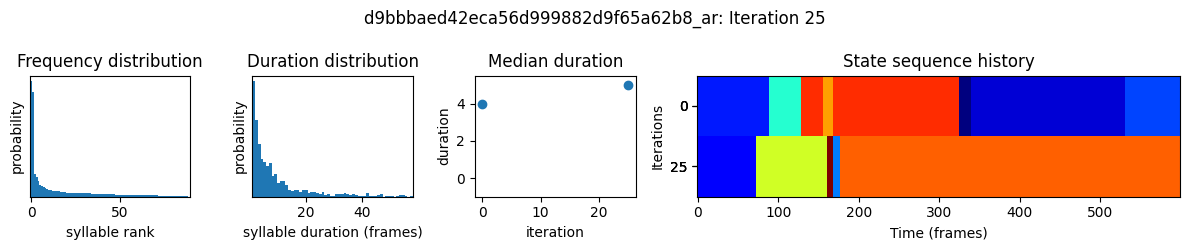

 98%|██████████████████████████████████▎| 50/51 [01:11<00:01,  1.20s/it]

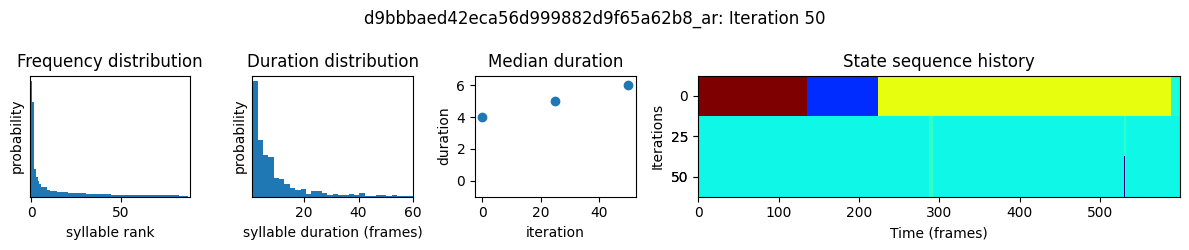

100%|███████████████████████████████████| 51/51 [01:15<00:00,  1.47s/it]


Outputs will be saved to /stelmo/nwb/moseq/projects/d9bbbaed42eca56d99
9882d9f65a62b8/d9bbbaed42eca56d999882d9f65a62b8_ar


 49%|█████████████████▏                 | 25/51 [01:17<00:33,  1.29s/it]

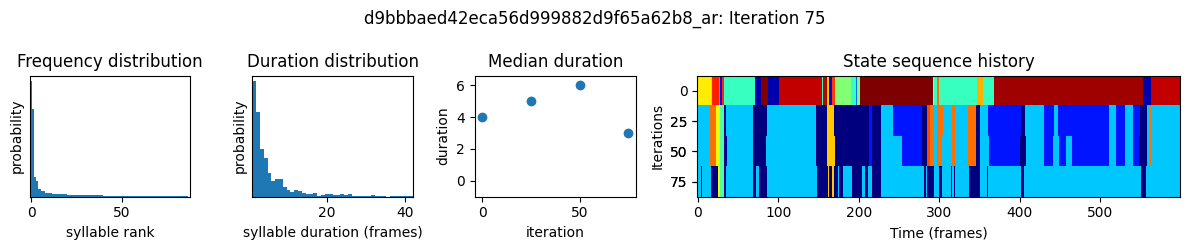

 98%|██████████████████████████████████▎| 50/51 [01:50<00:01,  1.28s/it]

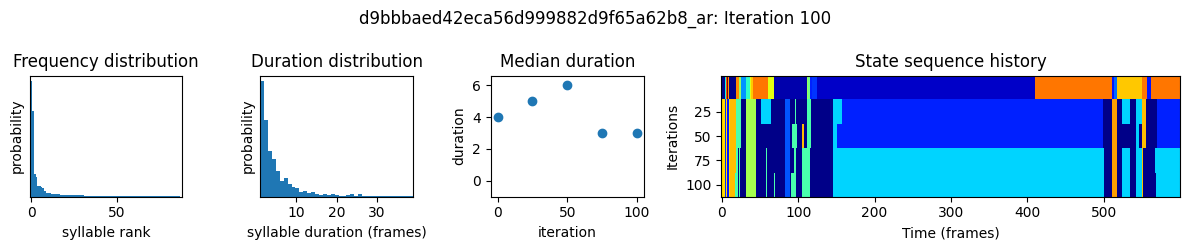

Reindexing: 100%|█████████████| 5/5 [00:04<00:00,  1.14model snapshot/s]


{'success_count': 1, 'error_list': []}

In [8]:
model_key = {
    "model_params_name": model_params_name,
    "pose_group_name": group_name,
}
MoseqModel().populate(model_key)

The model is now trained and accessible through the the `MoseqModel` table.

In [9]:
trained_model = MoseqModel().fetch_model(model_key)
trained_model

{'hypparams': {'ar_hypparams': {'K_0': array([[10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.],
          [ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.],
          [ 0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.

We can also analyze components of the trained model; 
ie. the pca breakdown of the pose skeleton

>=90.0% of variance exlained by 6 components.


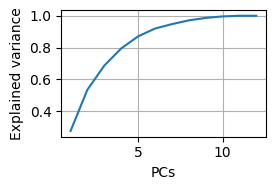

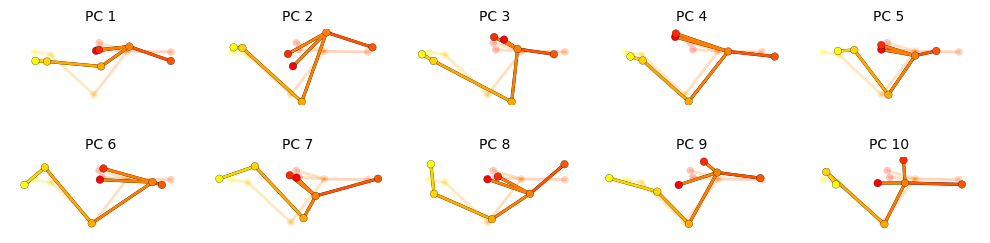

In [6]:
table = MoseqModel() & model_key
table.analyze_pca()

as well as average trajectories for each syllable

Saving trajectory plots to /stelmo/nwb/moseq/projects/d9bbbaed42eca56d999882d9f65a62b8/d9bbbaed42eca56d999882d9f65a62b8_ar/trajectory_plots


Generating trajectory plots: 100%|████████| 3/3 [00:01<00:00,  2.02it/s]


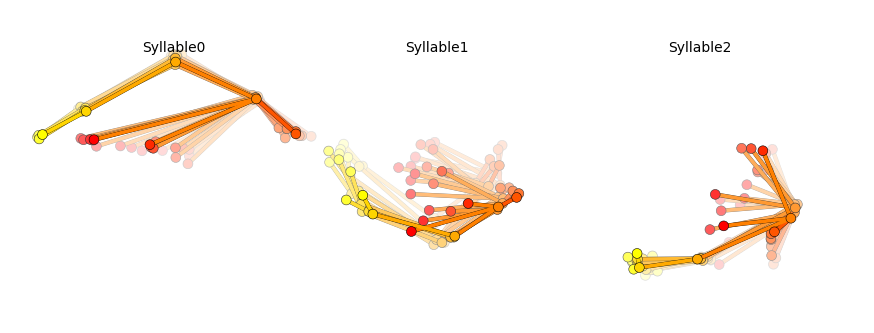

In [11]:
table.generate_trajectory_plots()

And example videos of each syllable. These are saved as mp4 files in the passed `output_dir`

In [ ]:
output_dir = "/path/to/save/videos/"
table.generate_grid_movies(output_dir=output_dir)

## Run data through the trained model

Now that we have a trained model, we can use it to convert pose data into behavioral 
syllables. We do so by combining a trained model with an epoch of pose data, and then
applying the populate command

In [17]:
%load_ext autoreload
%autoreload 2
from spyglass.behavior.v1.moseq import MoseqSyllableSelection, MoseqSyllable

# Make a selection table entry defining the pose data and moseq model to use
pose_key = (
    PoseGroup().Pose().fetch("pose_merge_id", as_dict=True)[0]
)  # can also use data outside of the training epochs
key = {**model_key, **pose_key, "num_iters": 3}
MoseqSyllableSelection().insert1(key, skip_duplicates=True)

# Run populate to apply the model to the pose data
MoseqSyllable().populate(key)
MoseqSyllable()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Applying model: 100%|█████████████████████| 3/3 [00:04<00:00,  1.37s/it]


Saved results to /stelmo/nwb/moseq/projects/d9bbbaed42eca56d999882d9f6
5a62b8/d9bbbaed42eca56d999882d9f65a62b8_ar/results.h5


/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning:

Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.

/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning:

Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.

[15:05:48][INFO] Spyglass: Writing new NWB file SC100020230912_LKNI5NCTIH.nwb
INFO:spyglass:Writing new NWB file SC100020230912_LKNI5NCTIH.nwb


pose_merge_id,pose_group_name,model_params_name,analysis_file_name name of the file,moseq_object_id
1f3fdc6d-d8d5-c283-846a-4830e85dcb32,tutorial_group,tutorial_kappa4_mini,SC100020230912_LKNI5NCTIH.nwb,e550ee2f-4744-46ac-a6f9-f9c87315c0ed


Text(0.5, 0, 'time (s)')

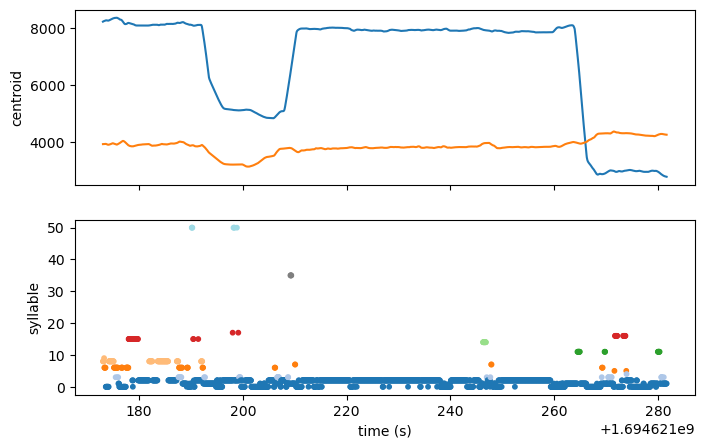

In [18]:
import matplotlib.pyplot as plt

moseq_df = (MoseqSyllable() & key).fetch1_dataframe()
moseq_df
ind = slice(1000, 3000)

fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
t = moseq_df.index.values[ind]
ax[0].plot(t, moseq_df["centroid x"].values[ind], label="x")
ax[0].plot(t, moseq_df["centroid y"].values[ind], label="y")
ax[1].scatter(
    t,
    moseq_df.syllable.values[ind],
    s=10,
    c=moseq_df.syllable.values[ind],
    cmap="tab20",
)
ax[0].set_ylabel("centroid")
ax[1].set_ylabel("syllable")
ax[1].set_xlabel("time (s)")

This concludes the tutorial for basic usage of the Moseq pipeline. Next, we will 
look at usage for extending training from a base model and leveraging spyglass's 
relational database to easily sweep through model hyperparameters

# Extend model training

There are many cases where you may want to begin trining from an existing model
rather than begin from scratch. Examples include continuing training an incompletely 
converged entry, or using a pre-trained base model and refining it to a particular set
of animals/ imaging conditions (ie. transfer learning).

The spyglass moseq pipeline allows for this style of iterative training. To do so, 
we will define a new entry in `MoseqModelParams` using the `make_training_extension_params`
method. This entry will have the same params as those used in model_key, except it
will point to the model_key entry for the `initial_model`

In [19]:
# Insert a training extension model entry
extension_params = MoseqModelParams().make_training_extension_params(
    model_key, num_epochs=100, skip_duplicates=True
)
print("initial model: ", extension_params["model_params"]["initial_model"])
new_params_key = {
    "model_params_name": extension_params["model_params_name"],
}
MoseqModelParams() & "model_params_name LIKE '%tutorial_kappa4%'"

initial model:  {'pose_group_name': 'tutorial_group', 'model_params_name': 'tutorial_kappa4_mini'}


model_params_name,model_params
tutorial_grouptutorial_kappa4_mini_extension001,=BLOB=
tutorial_kappa4_mini,=BLOB=


This extension model can then be trained following the same steps as before

Outputs will be saved to /stelmo/nwb/moseq/projects/45522739aed0cce276
67e45026e3e32c/45522739aed0cce27667e45026e3e32c


 25%|████████▍                         | 25/101 [00:34<01:42,  1.35s/it]

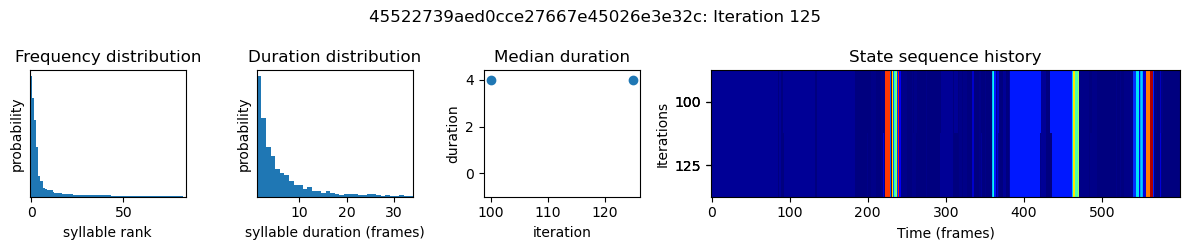

 50%|████████████████▊                 | 50/101 [01:09<01:09,  1.35s/it]

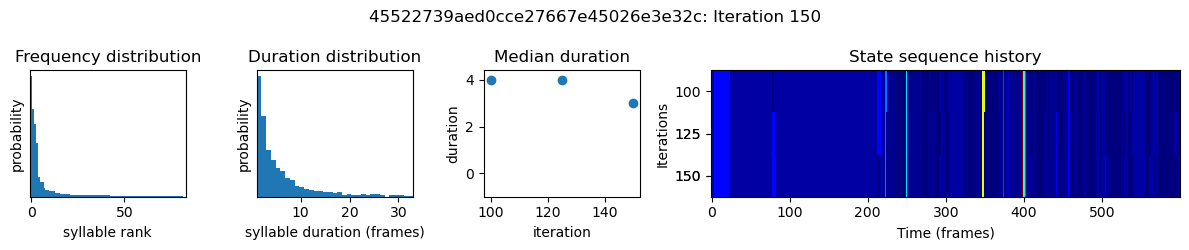

 74%|█████████████████████████▏        | 75/101 [01:44<00:35,  1.35s/it]

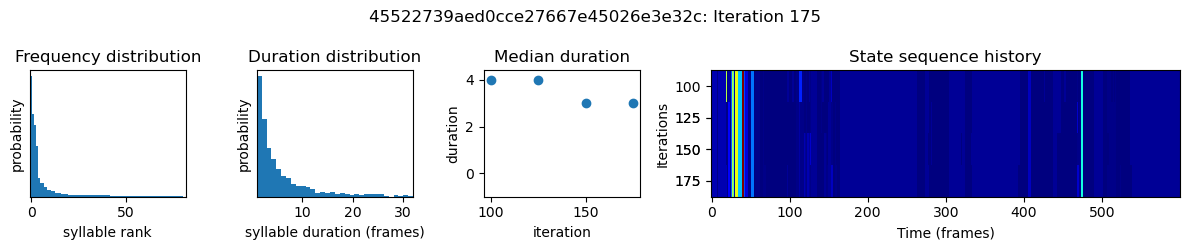

 99%|████████████████████████████████▋| 100/101 [02:18<00:01,  1.36s/it]

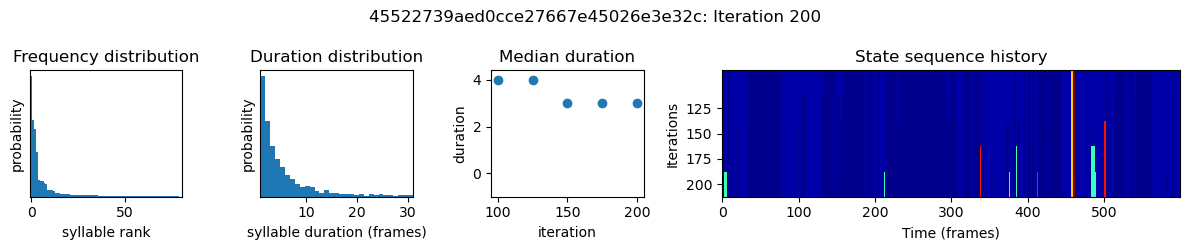

Reindexing: 100%|█████████████| 5/5 [00:01<00:00,  4.67model snapshot/s]


In [20]:
new_model_key = {
    **new_params_key,
    "pose_group_name": model_key["pose_group_name"],
}
MoseqModelSelection().insert1(new_model_key, skip_duplicates=True)
MoseqModel().populate(new_model_key)

# Hyperparameter search (kappa)

The relational database structure makes it relatively easy to train and organize 
multiple models on the same data. Here we demonstrate leveraging this architecture to
test values of `kappa` in the moseq model. The `kappa` value determines the rate
of syllable transitions, with larger values corresponding to longer syllables 
([moseq docs](https://keypoint-moseq.readthedocs.io/en/latest/advanced.html#automatic-kappa-scan)).
This value will likely need tuned for your specific data to achieve a syllable 
distribution at appropriate timescales.

To do so we will make a set of parameter entries with varying values of kappa and then
training an initial model for each. Looking at the results above, we see a shorter
median distribution (~3 frames = 100ms) than we would like 
([recommended ~400ms](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#modeling))
. We will therefore try several parameter sets with larger kappa values.



In [26]:
original_params = (MoseqModelParams() & model_key).fetch1("model_params")

new_params_key_list = []
for i in [5, 6, 7, 8]:
    new_params = original_params.copy()
    new_params["kappa"] = 10**i
    new_params["num_epochs"] = 100
    new_model_params_name = f"tutorial_kappa{i}_mini"
    new_params_key = {
        "model_params_name": new_model_params_name,
        "model_params": new_params,
    }
    new_params_key_list.append(new_params_key)
    MoseqModelParams().insert1(new_params_key, skip_duplicates=True)

MoseqModelParams() & "model_params_name LIKE '%tutorial_kappa%'"

model_params_name,model_params
tutorial_grouptutorial_kappa4_mini_extension001,=BLOB=
tutorial_kappa4_mini,=BLOB=
tutorial_kappa5_mini,=BLOB=
tutorial_kappa6_mini,=BLOB=
tutorial_kappa7_mini,=BLOB=
tutorial_kappa8_mini,=BLOB=


We can now train a model for each of these entries. We are training several different
models here, so depending on your hardware, now may be a good time for a coffee break.

Outputs will be saved to /stelmo/nwb/moseq/projects/411c8460ca6c2e53b6
e62826b7e49bd7/411c8460ca6c2e53b6e62826b7e49bd7_ar


 49%|█████████████████▏                 | 25/51 [00:32<00:33,  1.27s/it]

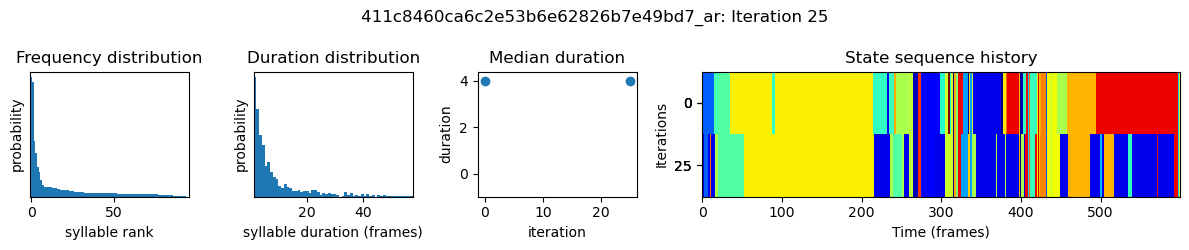

 98%|██████████████████████████████████▎| 50/51 [01:05<00:01,  1.27s/it]

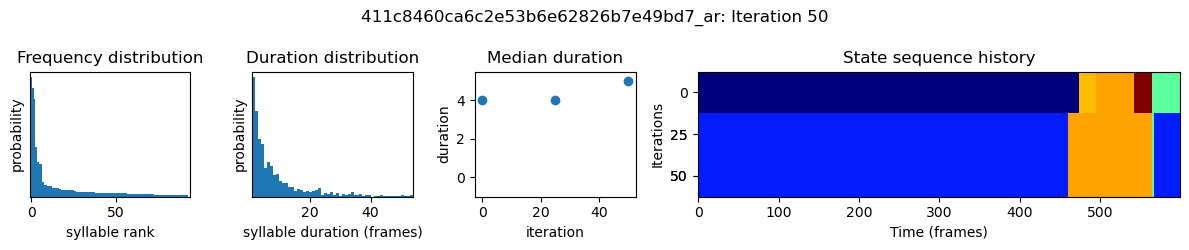

100%|███████████████████████████████████| 51/51 [01:07<00:00,  1.32s/it]
/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/keypoint_moseq/fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to /stelmo/nwb/moseq/projects/411c8460ca6c2e53b6
e62826b7e49bd7/411c8460ca6c2e53b6e62826b7e49bd7_ar


 25%|████████▍                         | 25/101 [00:33<01:40,  1.32s/it]

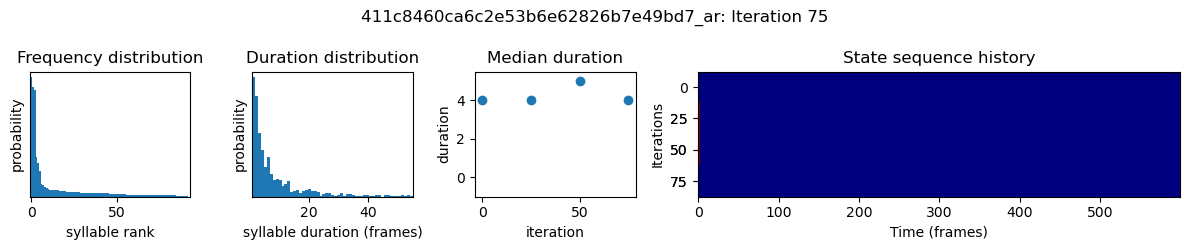

 50%|████████████████▊                 | 50/101 [01:06<01:07,  1.32s/it]

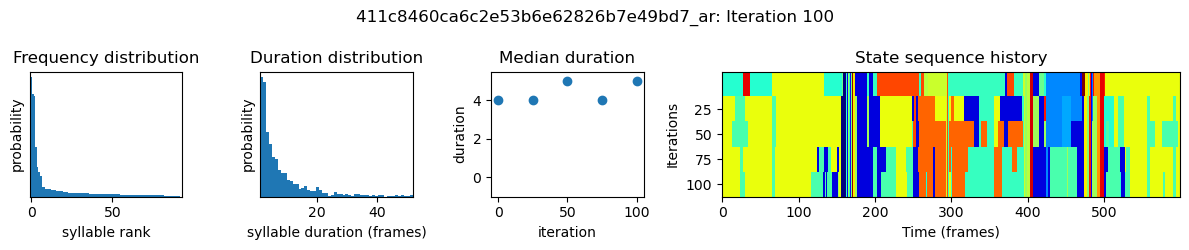

 74%|█████████████████████████▏        | 75/101 [01:40<00:34,  1.32s/it]

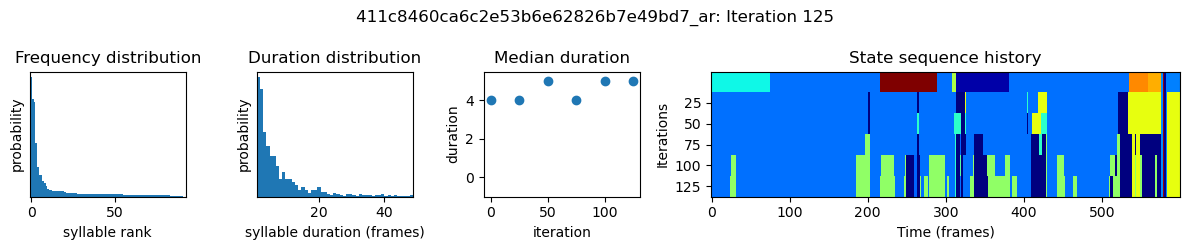

 99%|████████████████████████████████▋| 100/101 [02:14<00:01,  1.32s/it]

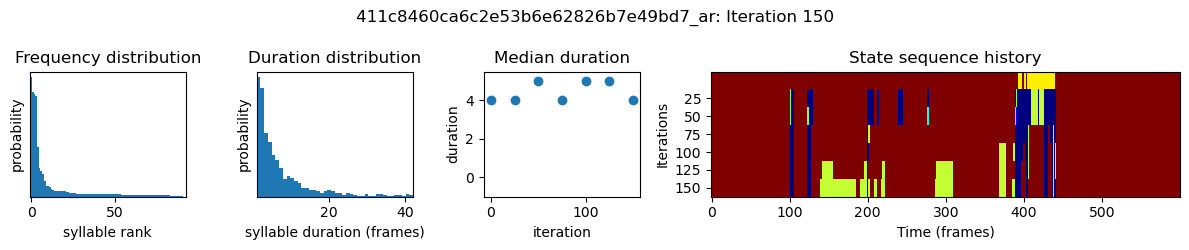

Reindexing: 100%|█████████████| 7/7 [00:01<00:00,  4.74model snapshot/s]


Outputs will be saved to /stelmo/nwb/moseq/projects/8b46f4d1412b3b5343
c7568134c8ecac/8b46f4d1412b3b5343c7568134c8ecac_ar


 49%|█████████████████▏                 | 25/51 [00:31<00:33,  1.27s/it]

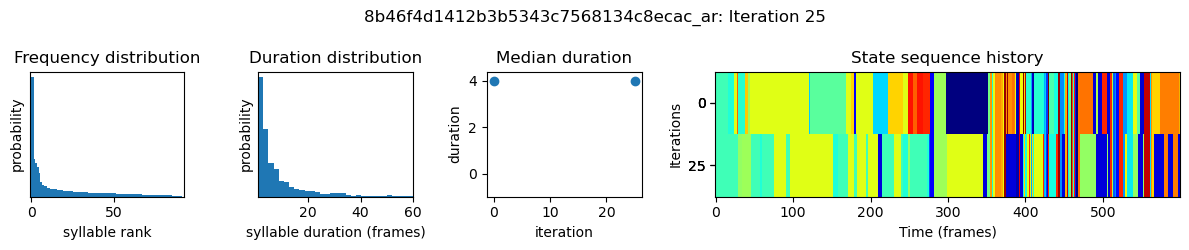

 98%|██████████████████████████████████▎| 50/51 [01:04<00:01,  1.27s/it]

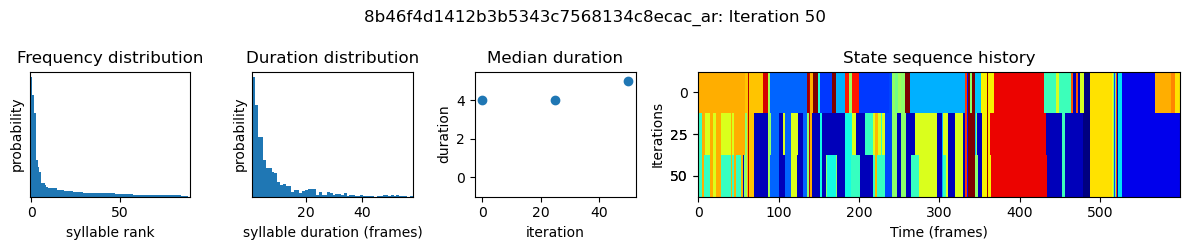

100%|███████████████████████████████████| 51/51 [01:06<00:00,  1.30s/it]
/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/keypoint_moseq/fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to /stelmo/nwb/moseq/projects/8b46f4d1412b3b5343
c7568134c8ecac/8b46f4d1412b3b5343c7568134c8ecac_ar


 25%|████████▍                         | 25/101 [00:33<01:40,  1.32s/it]

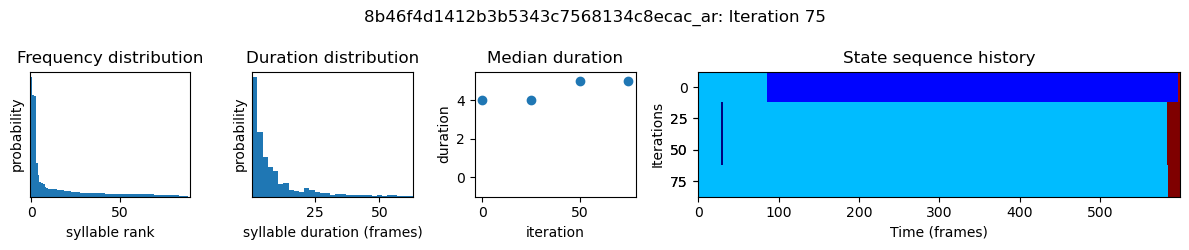

 50%|████████████████▊                 | 50/101 [01:07<01:07,  1.32s/it]

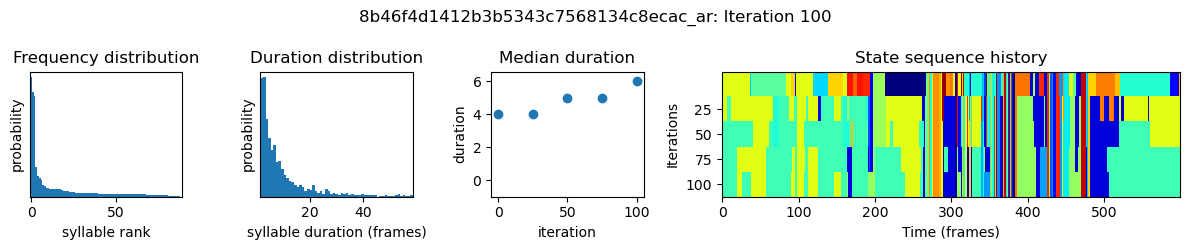

 74%|█████████████████████████▏        | 75/101 [01:40<00:34,  1.32s/it]

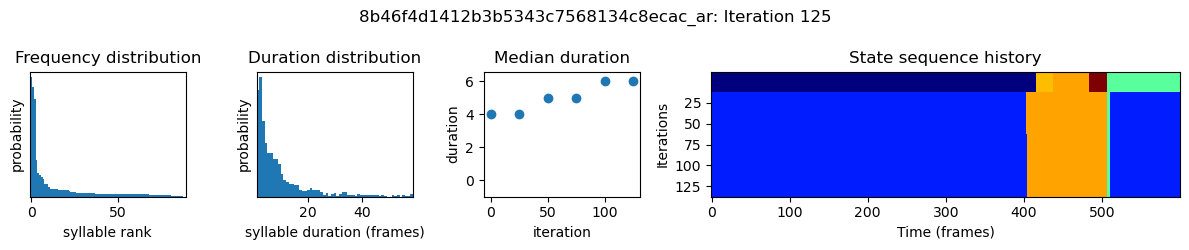

 99%|████████████████████████████████▋| 100/101 [02:14<00:01,  1.32s/it]

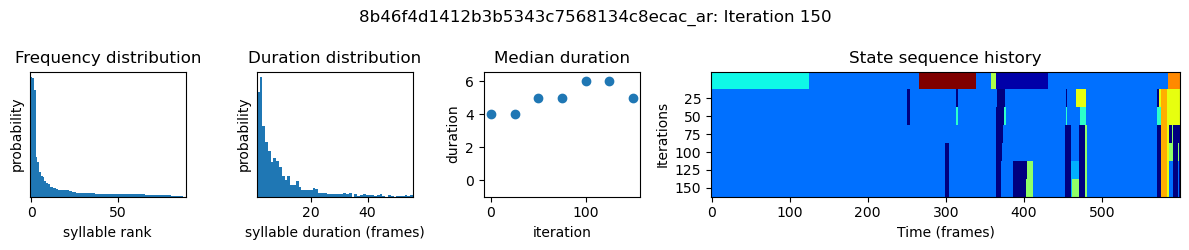

Reindexing: 100%|█████████████| 7/7 [00:01<00:00,  4.86model snapshot/s]


Outputs will be saved to /stelmo/nwb/moseq/projects/aef642d24bf39d00d3
4f4f187f20c545/aef642d24bf39d00d34f4f187f20c545_ar


 49%|█████████████████▏                 | 25/51 [00:32<00:33,  1.27s/it]

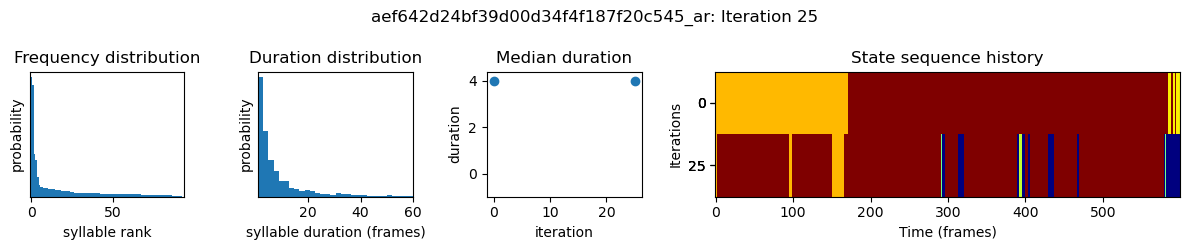

 98%|██████████████████████████████████▎| 50/51 [01:04<00:01,  1.27s/it]

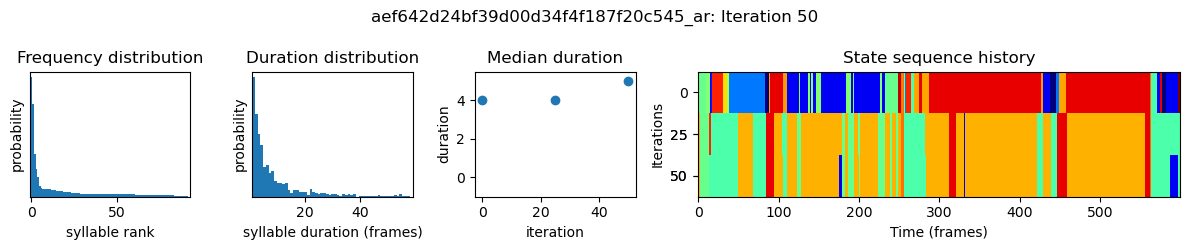

100%|███████████████████████████████████| 51/51 [01:06<00:00,  1.31s/it]
/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/keypoint_moseq/fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to /stelmo/nwb/moseq/projects/aef642d24bf39d00d3
4f4f187f20c545/aef642d24bf39d00d34f4f187f20c545_ar


 25%|████████▍                         | 25/101 [00:33<01:40,  1.32s/it]

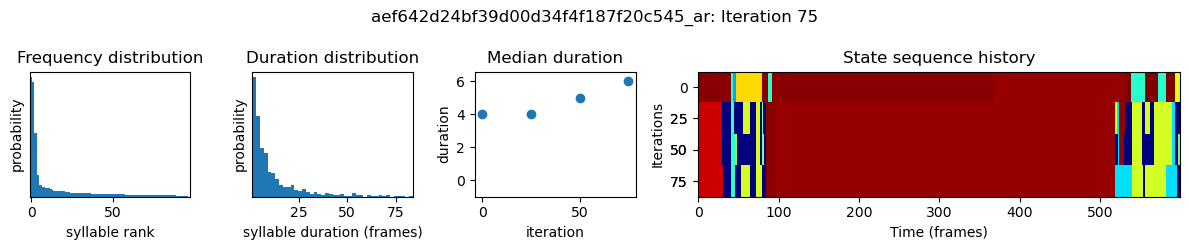

 50%|████████████████▊                 | 50/101 [01:06<01:07,  1.32s/it]

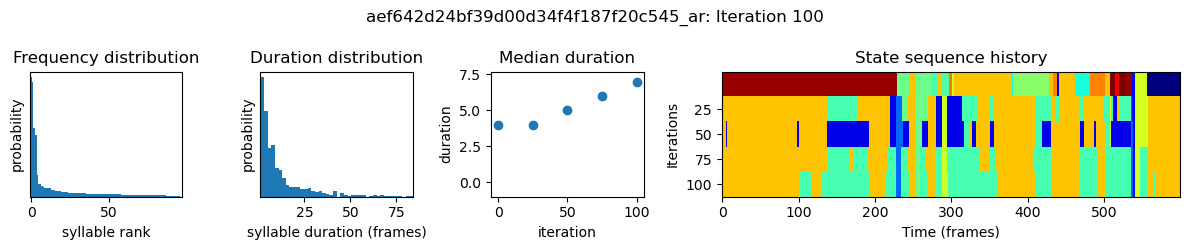

 74%|█████████████████████████▏        | 75/101 [01:40<00:34,  1.32s/it]

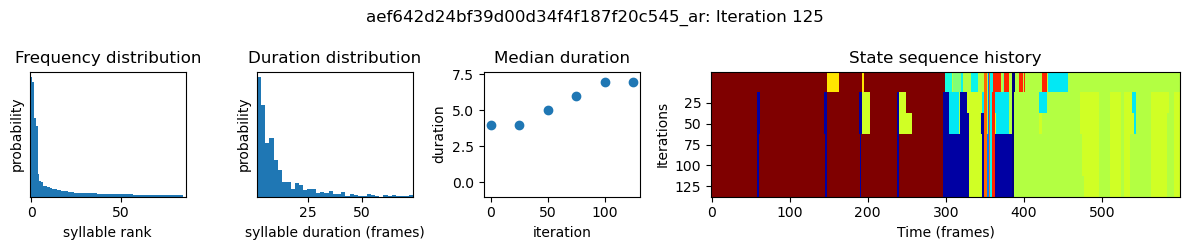

 99%|████████████████████████████████▋| 100/101 [02:14<00:01,  1.32s/it]

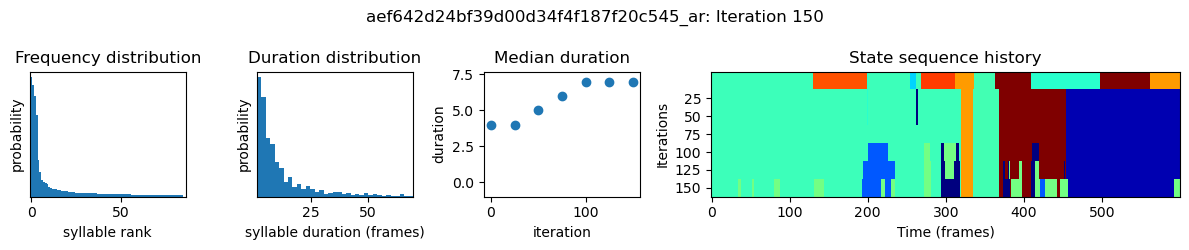

Reindexing: 100%|█████████████| 7/7 [00:01<00:00,  4.72model snapshot/s]


Outputs will be saved to /stelmo/nwb/moseq/projects/3230c67ed1b7a904a1
73d32a721f8e4c/3230c67ed1b7a904a173d32a721f8e4c_ar


 49%|█████████████████▏                 | 25/51 [00:31<00:33,  1.27s/it]

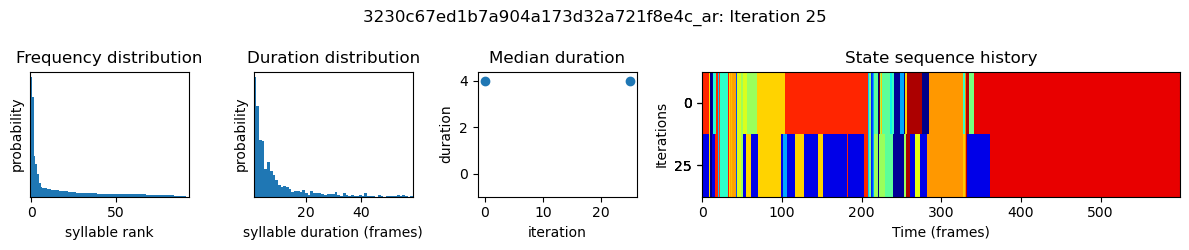

 98%|██████████████████████████████████▎| 50/51 [01:04<00:01,  1.27s/it]

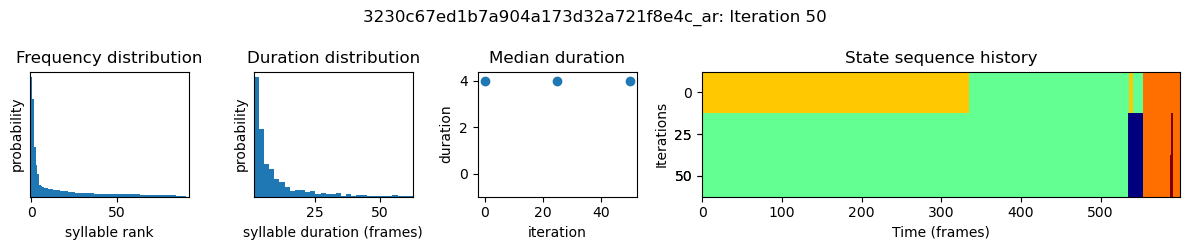

100%|███████████████████████████████████| 51/51 [01:06<00:00,  1.30s/it]
/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/keypoint_moseq/fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to /stelmo/nwb/moseq/projects/3230c67ed1b7a904a1
73d32a721f8e4c/3230c67ed1b7a904a173d32a721f8e4c_ar


 25%|████████▍                         | 25/101 [00:33<01:40,  1.32s/it]

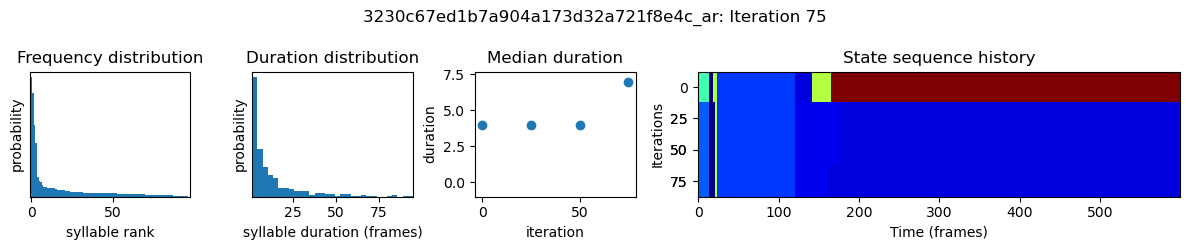

 50%|████████████████▊                 | 50/101 [01:07<01:07,  1.32s/it]

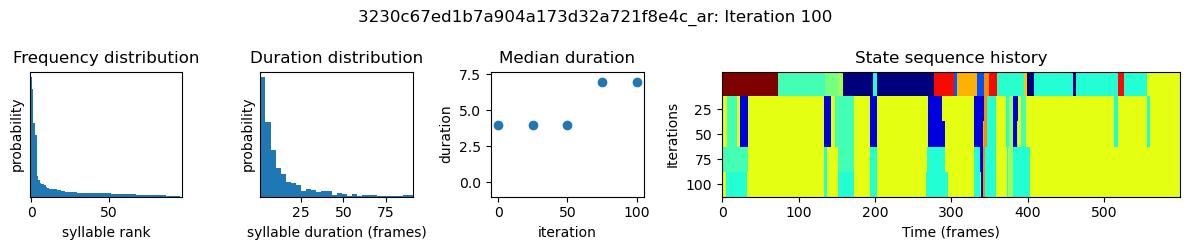

 74%|█████████████████████████▏        | 75/101 [01:40<00:34,  1.32s/it]

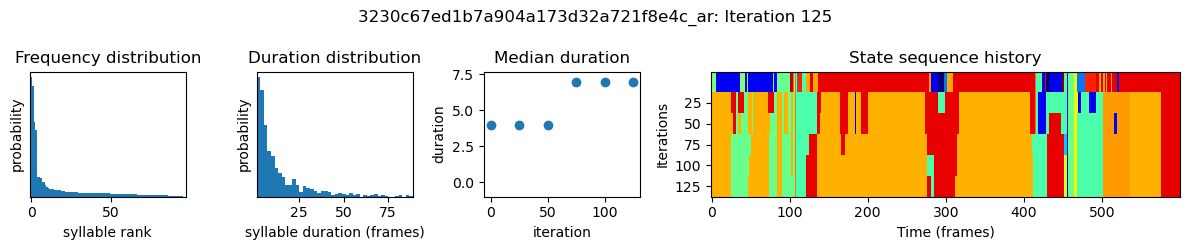

 99%|████████████████████████████████▋| 100/101 [02:14<00:01,  1.32s/it]

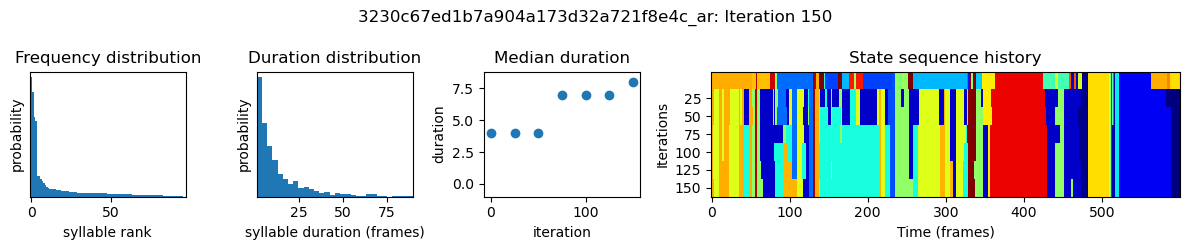

Reindexing: 100%|█████████████| 7/7 [00:01<00:00,  4.82model snapshot/s]


In [27]:
for new_params_key in new_params_key_list:
    new_model_key = {
        "model_params_name": new_params_key["model_params_name"],
        "pose_group_name": model_key["pose_group_name"],
    }
    MoseqModelSelection().insert1(new_model_key, skip_duplicates=True)
MoseqModel().populate()

You can then choose the model that best matches your syllable duration of interest and 
continue training it using the training extension described above

In [28]:
# print out link to the pdf of training results (includes syllable durations)
for new_params_key in new_params_key_list:
    new_model_key = {
        "model_params_name": new_params_key["model_params_name"],
        "pose_group_name": model_key["pose_group_name"],
    }
    training_results_path = MoseqModel().get_training_progress_path(
        new_model_key
    )
    print(
        f"{new_model_key['model_params_name']} training results: {training_results_path}"
    )

tutorial_kappa5_mini training results: /stelmo/nwb/moseq/projects/411c8460ca6c2e53b6e62826b7e49bd7/411c8460ca6c2e53b6e62826b7e49bd7_ar/fitting_progress.pdf
tutorial_kappa6_mini training results: /stelmo/nwb/moseq/projects/8b46f4d1412b3b5343c7568134c8ecac/8b46f4d1412b3b5343c7568134c8ecac_ar/fitting_progress.pdf
tutorial_kappa7_mini training results: /stelmo/nwb/moseq/projects/aef642d24bf39d00d34f4f187f20c545/aef642d24bf39d00d34f4f187f20c545_ar/fitting_progress.pdf
tutorial_kappa8_mini training results: /stelmo/nwb/moseq/projects/3230c67ed1b7a904a173d32a721f8e4c/3230c67ed1b7a904a173d32a721f8e4c_ar/fitting_progress.pdf
